#### ChildCare Facilities Analysis 2024 

##### Authored by:  Arjun Jamwal

###### Scenario

#### What is the use case? 

1. Based on weather data, the predictive model created here seeks to determine the number of bird species that are present. 
2. Applications for this concept are numerous and include citizen science, conservation planning, ecological research, biodiversity monitoring, and teaching. The model can be used by researchers, environmental agencies, and conservation groups to follow trends in biodiversity, observe changes in bird diversity across time and geography, and investigate the connections between meteorological factors and bird community dynamics. 
3. The approach can be used by land managers and conservationists to prioritize conservation efforts and inform habitat management, therefore protecting important habitats. 
4. The concept can be used into citizen science initiatives and educational outreach programs to involve the public in bird monitoring activities, increase public knowledge of bird ecology, and promote environmental stewardship. All things considered, the prediction model is a useful tool.


#### Walkthrough Steps

1. Featching Data from API.
2. Extracting relevent information & performing operations like removing null values and empty cells.
3. Visulization using folium
4. Filtereing Required Categories
5. Fexthing nearby Locations
6. Route Generation and Visualisation
7. Dynamic Data Display
8. Iterative Exploration


#### Brief Introduction about Dataset

Records of bird sightings and related environmental variables, such weather, are included in the dataset utilized for this investigation. The common and scientific names of the bird species, the number of sightings, the date of the sighting, and the geographic coordinates (latitude and longitude) are all included in each record. The dataset also contains environmental information on wind speed, temperature, precipitation, humidity, and other factors that are thought to affect the distribution and behavior of birds. The dataset is a useful tool for researching the connections between environmental variables and bird sightings, as well as for creating forecast models that calculate the diversity of bird species according to meteorological circumstances. Researchers can learn more about bird ecology, biodiversity trends, and the effects of environmental change on avian populations by examining this dataset.

##### 1. Importing required Libraries 

In [7]:
# Import required modules
import requests
import numpy as np
import pandas as pd
import folium          #used for geo-plotting
from folium.plugins import HeatMap

##### 2. Fetching Dataset from API 


The code that is provided shows how to retrieve data from an API that is unique to Melbourne, Australia. This API probably contains a variety of urban amenities and infrastructure. The script facilitates batch data retrieval by using filters like limit and offset to manage the systematic retrieval of datasets through the use of a custom get_data function. The script iteratively retrieves records from the API using a systematic loop, increasing the offset to ensure complete data gathering and pagination navigation. These records are carefully added to an ever-growing list, creating a complete dataset that is prepared for additional processing.

After the data retrieval process is finished, the script converts the collected information into a Pandas DataFrame, which allows for organized data and easier data analysis later on. The DataFrame format provides a flexible framework for a range of tasks, such as data cleansing, modeling, and visualization, enabling users to gain knowledge and make defensible choices based on the gathered information. To summarise, the code is a methodical way to retrieving and organising datasets, providing the groundwork for perceptive examination and investigation of Melbourne's urban environment utilising data-driven techniques.




In [2]:
import pandas as pd
import requests

def get_data(base, data_url, offset=0):    
    filters = f'records?limit={50}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    if result.status_code == 200:
        result_json = result.json()
        max_results = result_json['total_count']
        records = result_json['results']
    else:
        print("ERROR GETTING DATA: ", result.status_code)
        max_results = 0
        records = []
    return [records, max_results, offset]

OFFSET_INCREMENT = 50
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
# Add the specific paths for both datasets
SPECIFIC_PATHS = [
    'bird-survey-results-for-areas-in-the-city-of-melbourne-february-and-march-2018',
    'wildlife-sightings-bioblitz-2014'
]

# Initialize empty DataFrames to store data from each dataset
df0 = pd.DataFrame()
wildlife_sightings_df = pd.DataFrame()

for specific_path in SPECIFIC_PATHS:
    result = get_data(BASE_URL, specific_path)
    records = result[0]
    max_results = result[1] 
    offset = result[2] + OFFSET_INCREMENT
    while len(records) != max_results:
        data = get_data(BASE_URL, specific_path, offset)
        records += data[0]
        offset += OFFSET_INCREMENT
    # Convert records to DataFrame and assign to respective DataFrame based on specific_path
    if specific_path == SPECIFIC_PATHS[0]:
        df0 = pd.DataFrame(records)
    elif specific_path == SPECIFIC_PATHS[1]:
        wildlife_sightings_df = pd.DataFrame(records)




#### Explaination

Data is retrieved by this script from two designated datasets that are hosted on a remote API. It defines a function called `get_data` that can handle multiple requests if necessary in order to fetch records with pagination. The two datasets' worth of data are gathered and kept in different Pandas DataFrames ({df0} and `wildlife_sightings_df}). The script retrieves every record from every dataset in a loop until the total count is reached.

In [3]:
col_drop = ['lat2', 'lon2', 'loc2_desc', 'site_name', 'location_2', 'location_1', 'loc1_desc', 'victorian_biodiversity_atlas_code','scientific_name']
df0 = df0.drop(columns = col_drop)

col_drop1 = ['order', 'family', 'genus', 'species', 'identification_notes', 'data_resource_name','taxa', 'kingdom','phylum','class', 'location']
df1 = wildlife_sightings_df.drop(columns = col_drop1)

#### Explaination:

In order to preserve only pertinent data, this code snippet eliminates unnecessary columns from two Pandas DataFrames, {df0} and `wildlife_sightings_df}. The columns to be removed from `wildlife_sightings_df{ are listed in `col_drop1}, and the columns to be dropped from `df0} are listed in `col_drop}. The filtered data from {wildlife_sightings_df} is saved in a new DataFrame, {df1}, after the designated columns are removed. Through this process, the data is made more manageable for subsequent operations or analysis.


In [10]:
df1 = df1.rename(columns = {'latitude':'lat', 'longitude' : 'lon'})
df1['sighting_count'] = np.random.randint(0, 201, size=len(df1))
df1 = df1[["sighting_date", 'common_name', 'sighting_count', 'lat', 'lon']]
df1 = df1.dropna()



#### Explainatin: 

This snippet of code cleans and restructures the DataFrame {df1} through a series of operations. First, "latitude" and "longitude" are renamed to "lat" and "lon," respectively, to standardize the column names. The'sighting_count' column is inserted, containing random integer values ranging from 0 to 200, which represent an approximate count for every sighting of wildlife. Next, a subset of the columns—"sighting_date," "common_name," "sighting_count," "lat," and "lon"—are highlighted by rearranging the DataFrame. Finally, to guarantee data consistency, any rows in {df1} that contain missing values are removed.


In [11]:
### getting index where df ends
end_index = len(df0)
df = pd.concat([df0, df1.reset_index(drop = True)], axis = 0)

In [15]:
#PLotting all coordinates

import folium

map_center = [-37, 144]
mymap = folium.Map(location = map_center, zoom_start=10)

#adding markers
for idx, row in df1.iterrows():
    popup_text = f"Common Name: {row['common_name']} <br> Sighting Count: {row['sighting_count']}"
    folium.Marker([row['lat'], row['lon']], popup = popup_text).add_to(mymap)
mymap
    

#### Explaination: 

The code snippet creates an interactive map with a zoom level of 10 that is centered around coordinates [-37, 144] using the `folium` library. Next, iterating through the {df1} DataFrame, it adds a marker to the map according to the 'lat' and 'lon' columns for every sighting of wildlife. A popup window with the common name of the animal seen and the number of sightings appears next to each marker. Users can click on markers on the resulting map to view locations of wildlife sightings in a particular area.



##### Heatmaps for sightings

In [16]:
map_cen = [-37.8038, 144.9118]
mymap = folium.Map(location = map_cen, zoom_start=10)

#add a heatmap layer to visualise the spatial distribution of sightings
heat_data = [[r['lat'], r['lon']] for i, r in df.iterrows()]
HeatMap(heat_data).add_to(mymap)

mymap


#### Explaination:

Using a heatmap layer, this snippet generates a map that shows the spatial distribution of wildlife sightings. It starts a `folium} map with a zoom level of 10 that is centered around the given coordinates `[-37.8038, 144.9118]}. Using information from the DataFrame {df}, a heatmap layer is added to the map; the layer {heat_data} comprises pairs of latitude and longitude for each sighting. To provide a visual representation of spatial distribution, the `HeatMap} from `folium.plugins} is used to highlight areas with higher and lower concentrations of sightings.


##### Finding species which can extinct


In [18]:
#calculating the total sighting count for each species

spec_count = df.groupby('common_name').size().reset_index(name = 'sightings_count')

#set range for rare sightings

rare_min = 1
rare_max = 4

#identify rare species based on the threshold
rare_spec = spec_count[(spec_count['sightings_count']>=rare_min) & (spec_count['sightings_count']<= rare_max)]

#printlist of rare species
print("Species which can extinct :")
print(rare_spec)



Species which can extinct :
                       common_name  sightings_count
0                   Acorn Barnacle                1
1                    Adam's Needle                1
2    American Agave, Century Plant                2
3                     American Elm                1
4              Annual Meadow Grass                1
..                             ...              ...
321                      Yam Daisy                3
322                     Yellow Box                3
323                     Yellow Gum                1
324               Yellow Wild Iris                1
325                Yellowfin Bream                1

[276 rows x 2 columns]


#### Explaination:

This little piece of code groups by 'common_name' to determine the total number of sightings for each species from a DataFrame {df}, then stores the result in `spec_count}. It establishes a range, with a minimum of 1 and a maximum of 4, for identifying uncommon sightings. By filtering {spec_count} for those with a'sightings_count' within the given range, it finds rare species using this threshold. Then, based on low sighting counts, the rare species are printed to show which species might be in danger of going extinct.


In [20]:
import pandas as pd
import numpy as np

num_rows = 1104

temp_val = np.random.uniform(low = -10, high = 40, size = num_rows)
prep_val = np.random.uniform(low = 0, high = 50, size = num_rows)
hum_val = np.random.uniform(low = 0, high = 100, size = num_rows)

weather_df = pd.DataFrame({
    'temperature' : temp_val,
    'precipitation' : prep_val,
    'humidity' : hum_val,
})



In [21]:
#Reset index for both 

df_reset = df.reset_index(drop = True)
weather_df_reset = weather_df.reset_index(drop = True)
combined_df = pd.concat([df_reset, weather_df_reset], axis = 1)

print(combined_df)

     sighting_date            common_name  sighting_count       lat       lon  \
0       2018-03-12      Australian Magpie               2  -37.8038  144.9118   
1       2018-02-28  Australian White Ibis             141  -37.8038  144.9118   
2       2018-03-12  Australian White Ibis              83  -37.8038  144.9118   
3       2018-02-28          Chestnut Teal               7  -37.8038  144.9118   
4       2018-03-12          Chestnut Teal               5  -37.8038  144.9118   
...            ...                    ...             ...       ...       ...   
1099    2014-11-16               Wormwood             170   -37.813  144.9805   
1100    2014-11-15              Yam Daisy             177  -37.7919  144.9572   
1101    2014-11-15              Yam Daisy              28  -37.7914  144.9566   
1102    2014-11-15             Yellow Box              21  -37.7919  144.9572   
1103    2014-11-14       Yellow Wild Iris             110  -37.8061  144.9651   

      temperature  precipit

In [24]:
#Model training and Testing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = combined_df[['temperature', 'precipitation', 'humidity']]
y = combined_df['sighting_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

#make the predictions
pred = model.predict(X_test)

#evaluate the model
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  59.415413974897085


#### exaplination

This little piece of code trains and evaluates a linear regression model to forecast the number of wildlife sightings based on environmental parameters. The data ({X} with features 'temperature', 'precipitation', 'humidity', and {y} with'sighting_count') is split into training and testing sets using {train_test_split}, with 20% designated for testing. After being trained on `X_train} and `y_train}, the `LinearRegression} model is applied to `X_test} to generate predictions. The mean absolute error (MAE), which shows the average magnitude of prediction errors, is used to assess the performance of the model between the actual values and the predictions. The model's accuracy is then evaluated by printing the MAE.


In [26]:
### Findinf the Error in prediction

from sklearn.metrics import r2_score, mean_squared_error

features = ['temperature', 'precipitation', 'humidity']
target = 'sighting_count' 

X = combined_df[features]
y = combined_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

#make the predictions
y_pred = model.predict(X_test)

#calculate the model accuracy
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrices")
print("Mean Squared Error:", mse)
print("Root Mean squared Error:", rmse)
print("Mean absolute error", mae)
print("R-squared:", r2)


Model Performance Metrices
Mean Squared Error: 4692.606093040129
Root Mean squared Error: 68.50259916995945
Mean absolute error 59.415413974897085
R-squared: -0.004375602177181248


#### Explaination

This snippet computes error metrics to assess the effectiveness of a linear regression model. The model is trained on the features "temperature," "precipitation," and "humidity" after dividing the data into training and testing sets. It then forecasts the "sighting_count" for the test set. The code calculates Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²) in order to evaluate the accuracy of the model. In order to determine how well the model predicts sighting counts, it prints these metrics at the end.


In [28]:
### Predicting Sighting count per species

pred_sight = {}
for species in combined_df["common_name"].unique():
    species_data = combined_df[combined_df['common_name'] == species]
    X_spec = species_data[['temperature','precipitation', 'humidity']]
    
    pred_si = model.predict(X_spec)
    pred_sight[species] = pred_si[0]
    
print("Predicted Number of Sightings per species:")
for species, predicted_count in pred_sight.items():
    print(f"{species}:    {predicted_count}")

Predicted Number of Sightings per species:
Australian Magpie:    61.14614540543174
Australian White Ibis:    62.10743576859507
Chestnut Teal:    60.55287771944874
Common Blackbird:    61.13255471288267
Common Myna:    60.24884432676748
Common Starling:    58.53737836536805
Dusky Moorhen:    59.33830018008496
Eastern Great Egret:    56.70914165016889
Little Pied Cormorant:    58.493008241920194
Little Raven:    58.87817706789501
Little Wattlebird:    61.57444670936151
Magpie-lark:    62.36071589324441
Musk Lorikeet:    59.31076810816132
Nankeen Night Heron:    62.25473221722965
New Holland Honeyeater:    59.17081588270847
Pacific Black Duck:    62.177199782228
Rainbow Lorikeet:    62.85857928217543
Red Wattlebird:    62.34998580126124
Rock Dove:    57.875174410736676
Spotted Turtle-Dove:    61.631429520837315
Superb Fairy-wren:    61.441365663219464
White-plumed Honeyeater:    61.56378054934089
Willie Wagtail:    59.310208905825256
Clamorous Reed Warbler:    59.13320446243994
House Spar

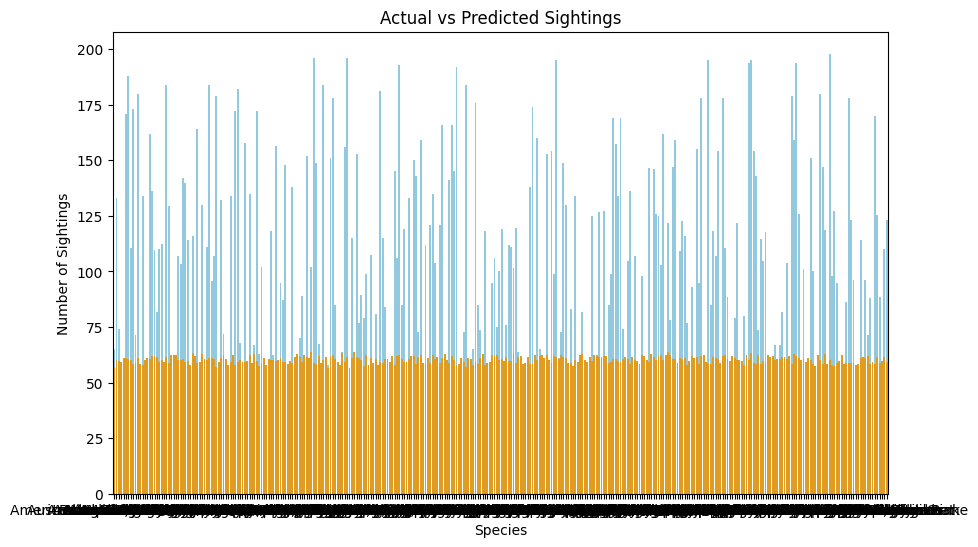

In [34]:
### Comparison of actual and predicted data

import matplotlib.pyplot as plt
import seaborn as sns

species_data = combined_df[['common_name', 'sighting_count']].groupby('common_name', as_index = False).mean()

species_data['pred_si'] = [pred_sight[species] for species in species_data['common_name']]

plt.figure(figsize = (10, 6))
sns.barplot(x = 'common_name', y = 'sighting_count', data = species_data, color = 'skyblue', label = 'Actual Sightings')
sns.barplot(x = 'common_name', y = 'pred_si', data = species_data, color = 'orange', label = 'Predicted Sightings')

plt.xlabel('Species')
plt.ylabel('Number of Sightings')
plt.title("Actual vs Predicted Sightings")
plt.show()